In [1]:
import tensorflow as tf
from deeponet import DeepONet
from utils import *
import matplotlib.pyplot as plt
import tqdm

2024-11-13 16:19:16.860840: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-13 16:19:16.937547: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
device = "/gpu:0" if tf.config.list_physical_devices('GPU') else "/cpu:0"
print("Device :", device)

Device : /gpu:0


In [ ]:
@tf.function(reduce_retracing=True)
def boundary_fn(x, boundaries = (0.0, 1.0)):
    return (x[..., 0] - boundaries[0]) * (x[..., 0] - boundaries[1]) * (x[..., 1] - boundaries[0]) * (x[..., 1] - boundaries[1]) 

model = DeepONet(
    n_branch = 64 * 64, 
    n_trunk = 2, 
    width = 50, 
    depth = 3, 
    output_dim = 128 * 128,
    activation = "relu", 
)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4, 
    decay_steps=20,  
    decay_rate=0.96,   
    staircase=True   
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

2024-11-13 16:19:26.050000: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14408 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-11-13 16:19:26.051120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14408 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:1b:00.0, compute capability: 8.6
2024-11-13 16:19:26.052056: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14408 MB memory:  -> device: 2, name: NVIDIA RTX A4000, pci bus id: 0000:3d:00.0, compute capability: 8.6
2024-11-13 16:19:26.052922: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 14408 MB memory:  -> device: 3, name: NVIDIA RTX A4000, pci bus id: 0000:3e:00.0, 

In [4]:
dataloader = DarcyDatasetLoader("DarcyDataset")
train_dataset, test_dataset = dataloader.get_split(0.2, batch_size = 128)

16384


In [5]:
def downsample(a, u):
    a = tf.expand_dims(a, axis=-1)  # Shape now [batch, height, width, 1]

    # Apply Max Pooling to downsample `a`
    pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
    a_downsampled = pooling_layer(a)

    # Remove the channel dimension if you want to return it to its original format
    a_downsampled = tf.squeeze(a_downsampled, axis=-1)
    return a_downsampled, u    

In [6]:
train_dataset = train_dataset.map(lambda a, u : downsample(a, u))
test_dataset  = test_dataset.map(lambda a, u : downsample(a, u)) 

In [7]:
coords = tf.meshgrid(tf.linspace(0.0, 1.0, 128), tf.linspace(0.0, 1.0, 128))
coords = tf.stack(coords, axis=-1)
coords = tf.reshape(coords, (-1, 2))

In [ ]:
epochs = 5000

@tf.function
def train_step(a_batch, u_batch):
    with tf.GradientTape() as tape:
        boundaries = boundary_fn(coords)
        predictions = model(tf.reshape(a_batch, (-1, 64*64)), coords) * boundaries
        loss = loss_fn(tf.reshape(u_batch, (-1 ,128*128)), predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Main training loop with tqdm and distributed training
for epoch in range(epochs):
    loss_avg = 0.0
    num_batches = 0
    for step, (a_batch, u_batch) in enumerate(train_dataset):
        loss_avg += train_step(a_batch, u_batch)
        num_batches += 1

    loss_avg /= num_batches
    print(f"Epoch[{epoch+1}/{epochs}] Loss : {loss_avg.numpy():.9e}", end="\r")


2024-11-13 16:19:28.963481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-13 16:19:29.037551: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd99eb3acb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-13 16:19:29.037598: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-11-13 16:19:29.037607: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A4000, Compute Capability 8.6
2024-11-13 16:19:29.037613: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA RTX A4000, Compute Capability 8.6
2024-11-13 16:19:29.037618: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA RTX A4000, Compute Capability 8.6
2024-11-13 16:19:29.037623: I te

In [9]:
coords_test = tf.meshgrid(tf.linspace(0.0, 1.0, 128), tf.linspace(0.0, 1.0, 128))
coords_test = tf.stack(coords_test, axis=-1)
coords_test = tf.reshape(coords_test, (-1, 2))

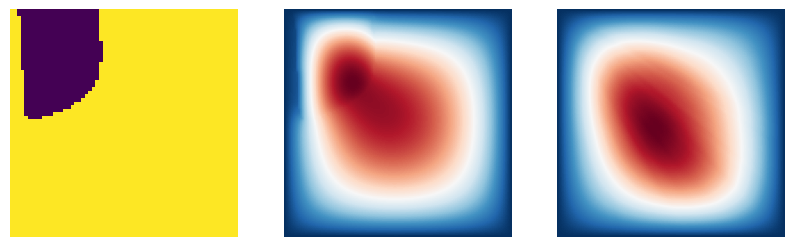

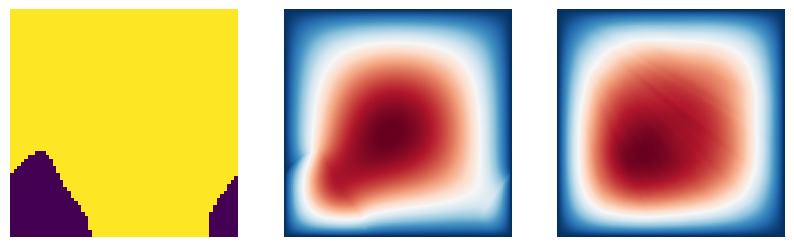

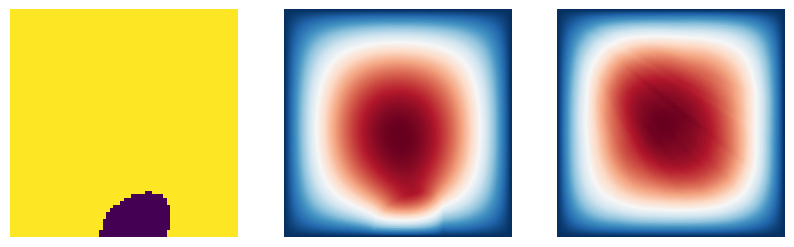

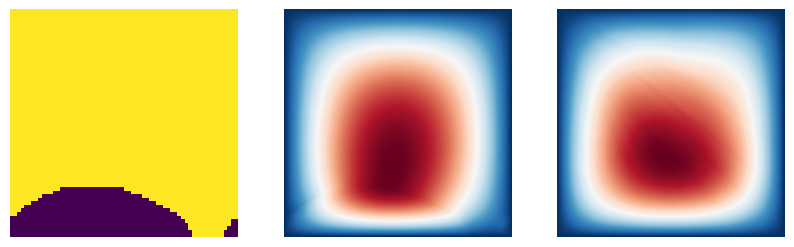

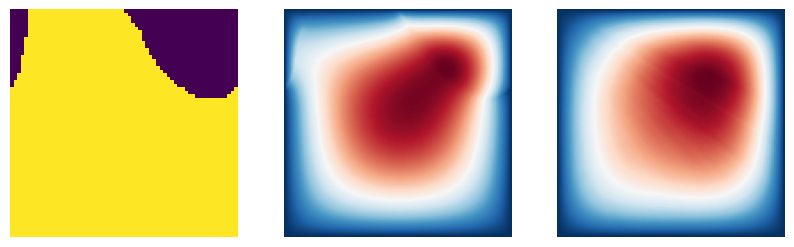

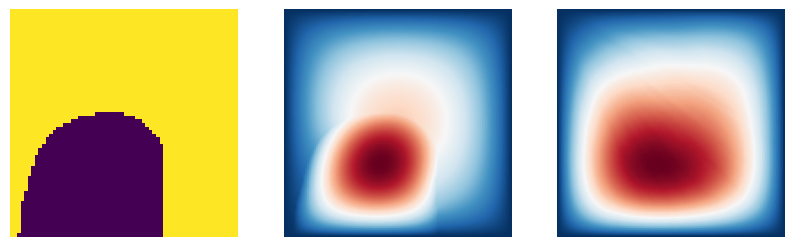

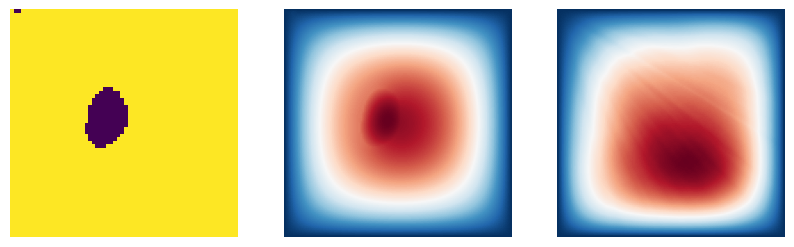

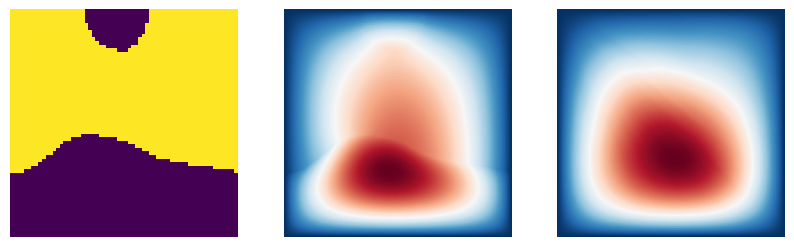

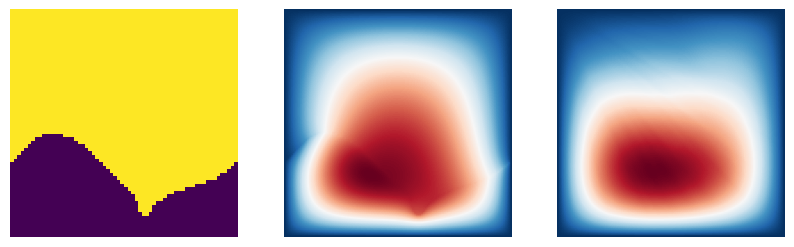

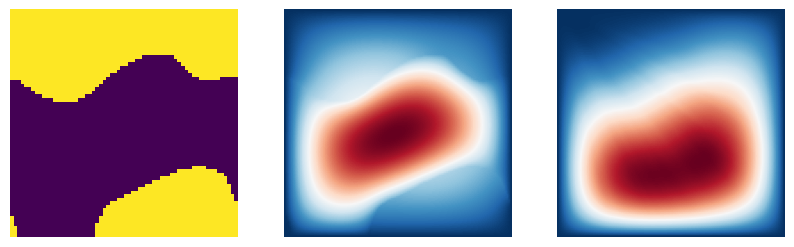

In [10]:
import matplotlib.pyplot as plt

for a, u in test_dataset.take(10):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    a = tf.reshape(a, (-1, 64*64))
    u = tf.reshape(u, (-1, 128*128))
    boundaries = boundary_fn(coords_test)
    u_pred = model(a, coords_test) * boundaries
    u_pred = tf.reshape(u_pred, (-1, 128*128))
    ax[0].imshow(tf.reshape(a[0], (64, 64)), cmap = "viridis")
    ax[0].set_axis_off()
    ax[1].imshow(tf.reshape(u[0], (128, 128)), cmap = "RdBu_r")
    ax[1].set_axis_off()
    ax[2].imshow(tf.reshape(u_pred[0], (128, 128)), cmap = "RdBu_r")
    ax[2].set_axis_off()
    
    plt.show()